In [66]:
#импортируем нужные либы
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#объявляем параметры подключения
connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.

In [24]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT room_type
FROM default.ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection)
df

,room_type
0,Private room
1,Entire home/apt
2,Entire home/apt
3,Private room
4,Entire home/apt
...,...
85202,Private room
85203,Private room
85204,Private room
85205,Private room


Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

price – цена за ночь
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.
В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [25]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT 
toFloat32OrNull(replaceRegexpAll( price, '[,$]', '')) as price ,
room_type
FROM default.ldn_listings
ORDER BY id ASC
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df

,price,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,300.0,Entire home/apt
3,150.0,Private room
4,65.0,Entire home/apt
...,...,...
995,110.0,Entire home/apt
996,110.0,Entire home/apt
997,65.0,Private room
998,100.0,Entire home/apt


In [26]:
df.groupby('room_type',as_index = False)\
.agg({'price':sum}).\
sort_values('price', ascending = False)

,room_type,price
0,Entire home/apt,67860.0
2,Private room,36818.0
1,Hotel room,268.0
3,Shared room,245.0


In [22]:
df.query('room_type == "Private room"').quantile(0.75)

price    60.0
Name: 0.75, dtype: float64

К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

In [30]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query2 = """
SELECT 
toFloat32OrNull(replaceRegexpAll( price, '[,$]', '')) as price,
toFloat32OrNull(review_scores_rating) as scores,
room_type as room_type
FROM default.ldn_listings
WHERE review_scores_rating != ''
ORDER BY id ASC
LIMIT 1000
"""
df2 = ph.read_clickhouse(query2, connection=connection)
df2

,price,scores,room_type
0,65.0,97.0,Private room
1,100.0,96.0,Entire home/apt
2,300.0,94.0,Entire home/apt
3,65.0,93.0,Entire home/apt
4,29.0,96.0,Private room
...,...,...,...
995,165.0,100.0,Entire home/apt
996,99.0,93.0,Private room
997,45.0,100.0,Private room
998,20.0,88.0,Private room


In [33]:
#группируем датафрейм по типу жилья и считаем среднее для цены и рейтинга

df2 = df2.groupby('room_type', as_index = False).\
agg({'price': 'mean', 'scores':'mean'})

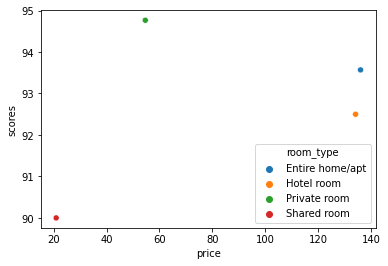

In [37]:
#используем sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

sns.scatterplot(data = df2, x = 'price', y = 'scores', hue = 'room_type')

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

host_id – идентификатор хозяина (уникальный)
host_verifications – какими способами хост подтвердил свой профиль

In [50]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query3 = """
SELECT 
distinct host_id  ,
host_verifications 

FROM default.ldn_listings
WHERE experiences_offered != 'none'

"""
df3 = ph.read_clickhouse(query3, connection=connection)
df3

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [51]:
#в ячейках находятся строковые представления списка. приводим их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта 

df3['host_verifications'] = df3['host_verifications'].apply(lambda x: x.strip().strip('[').strip(']').replace("'","").split(','))

In [53]:
#используем методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации
df3.explode('host_verifications')['host_verifications'].value_counts()

email                     1345
 phone                    1345
 reviews                  1309
 government_id            1196
 jumio                    1115
 offline_government_id     469
 work_email                279
 facebook                  270
 selfie                    252
 identity_manual           227
 manual_offline             70
 google                     34
 kba                        27
phone                       16
 manual_online              16
 sent_id                     6
Name: host_verifications, dtype: int64

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count

In [13]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query4 = """
SELECT 
neighbourhood_cleansed,
experiences_offered,
count(id) as experiences_count 

FROM default.ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100

"""
df4 = ph.read_clickhouse(query4, connection=connection)
df4

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


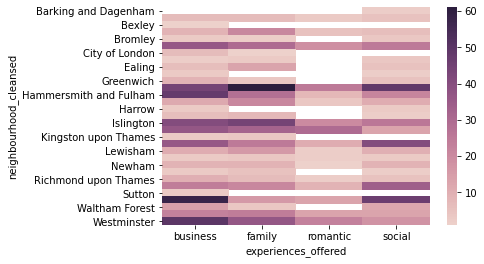

In [54]:
#визуализируем пивот (индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района)

sns.heatmap(df4.pivot(index = 'neighbourhood_cleansed', columns = 'experiences_offered', values = 'experiences_count'), cmap=sns.cubehelix_palette(as_cmap=True))

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')

In [55]:
query5 = """
SELECT 
room_type,
toFloat32OrNull(replaceRegexpAll( price, '[,$]', '')) as price 
FROM default.ldn_listings
WHERE experiences_offered != 'none'

"""
df5 = ph.read_clickhouse(query5, connection=connection)
df5


,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NameError: name 'plt' is not defined

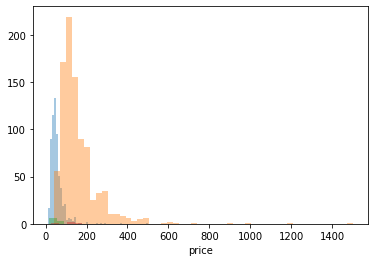

In [16]:
#отображаю исходные распределения цен для каждого типа жилья

sns.distplot(df5.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df5.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df5.query("room_type=='Shared room'").price, kde=False, label='Shared room')
sns.distplot(df5.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
plt.legend()
plt.show()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


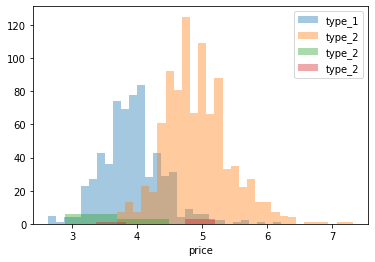

In [56]:
#отображаю исходные распределения цен для каждого типа жилья, логарифмированные значения (np.log()

sns.distplot(np.log(df5.query("room_type=='Private room'").price), kde=False, label='type_1')
sns.distplot(np.log(df5.query("room_type=='Entire home/apt'").price), kde=False, label='type_2')
sns.distplot(np.log(df5.query("room_type=='Shared room'").price), kde=False, label='type_2')
sns.distplot(np.log(df5.query("room_type=='Hotel room'").price), kde=False, label='type_2')
plt.legend()
plt.show()

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь
first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
Ограничение поставьте на 1000 строк.

In [60]:
query6 = """
SELECT 
room_type,
toFloat32OrNull(replaceRegexpAll( price, '[,$]', '')) as price,
first_review
FROM default.ldn_listings
WHERE first_review > '2010-01-01'

LIMIT 1000

"""
df6 = ph.read_clickhouse(query6, connection=connection)
df6

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [61]:
#приводим к типу даты
df6['first_review'] = pd.to_datetime(df6.first_review)

In [63]:
#приводим к типу даты = год
df6['first_review'] = pd.DatetimeIndex(df6.first_review).year

In [64]:
df6

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


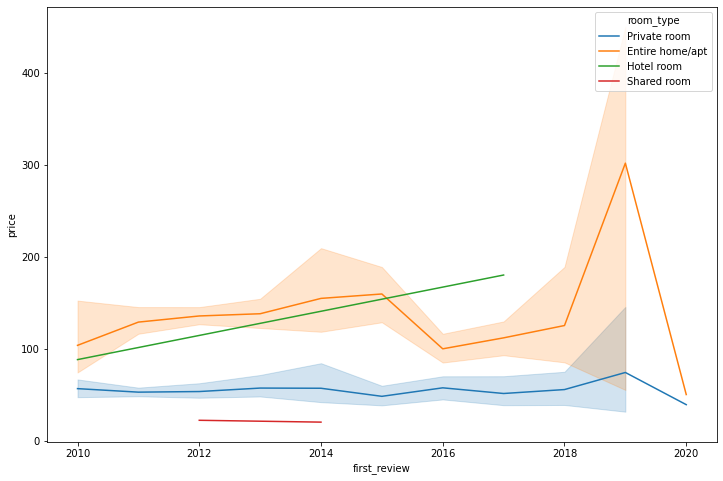

In [65]:
#строю график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X)

plt.figure(figsize=(12, 8))
sns.lineplot(x='first_review',y='price',hue='room_type',data=df6)